# Conditional PDFs of a Gaussian mixture model

A Gaussian mixture model (GMM) is a weighted combination of (possibly multivariate) normal distributions:
$$
f_{\rm GMM}({\rm x}) = \sum_{i=1}^n \pi_i \mathcal{N}({\rm x} | \mu_i, \Sigma_i)\,,
$$
where the component weights $\pi_i$ sum to 1 and each individual Gaussian is properly normalized. If the random variable ${\rm x}$ is multivariate (i.e. a vector) then we can consider the *conditional* distribution of some parts of ${\rm x}$ (e.g. ${\rm x}_1$) conditioned on other parts ${\rm x}_2$. In this case, the GMM yields
$$
f_{\rm GMM}({\rm x}_1|{\rm x}_2) = \frac{f({\rm x}_1,{\rm x}_2)}{f({\rm x}_2)}\,,
$$
which is just the usual definition of a conditional probability. The denominator is the evidence for ${\rm x}_2$, defined as 
$$
f({\rm x}_2) = \sum_{i=1}^n \pi_i \mathcal{N}({\rm x}_2| \mu_{i,2}, \Sigma_{i,2})\,,
$$
which is the sum over the unconditional (marginalized) Gaussian probabilities for ${\rm x}_2$ weighted by the component weights. The numerator is simply the sum of the joint probabilities written in the first equation
$$
f({\rm x} = [{\rm x}_1,{\rm x}_2]^T) = \sum_{i=1}^n \pi_i \mathcal{N}({\rm x} | \mu_i, \Sigma_i)\,.
$$

In this notebook we will look at some simple examples of how to evaluate properties of a conditional GMM.

In [1]:
import ConditionalGMM as cgmm

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
np.random.seed(0)

In [2]:
plt.rc("text", usetex=True)
plt.rc("font", size=20, family="serif")
colors = ["blue", "orange", "green"]

In [3]:
# generate a random sample from two components
n_samples = 600 #for each component
weights = np.array([0.5, 0.5])

# generate spherical data that is off center
means1 = np.array([6., -5.])
C1 = np.eye(2)
shifted_gaussian = sp.stats.multivariate_normal.rvs(mean=means1, cov=C1, size=int(n_samples*weights[0]))

# generate zero centered stretched Gaussian data
means2 = np.array([0., -10.])
C2 = np.array([[5, 2.], [ 2., 0.98]])
stretched_gaussian = sp.stats.multivariate_normal.rvs(mean=means2, cov=C2, size=int(n_samples*weights[1]))

# concatenate the two datasets into the final training set
X_train = np.vstack([shifted_gaussian, stretched_gaussian])

In [4]:
means = np.array([means1, means2])
covs = np.array([C1, C2])
fixed_inds = [0] #NOTE: we are conditioning in x
cGMM = cgmm.CondGMM(weights, means, covs, fixed_inds)

In [5]:
# display predicted scores by the model as a contour plot
x = np.linspace(-8., 13.)
y = np.linspace(-21., 3.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
#NOTE: we are conditioning on x, so the x values go in the second argument (XX[i,0])
lnpdf = np.array([cGMM.joint_logpdf([XX[i,1]], [XX[i,0]]) for i in range(len(XX))])
lnpdf = lnpdf.reshape(X.shape)

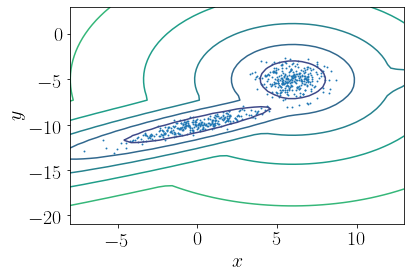

In [6]:
CS = plt.contour(X, Y, -lnpdf, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10))
#CB = plt.colorbar(CS, shrink=0.8, extend='both')
#CB.set_label(r"$-\ln P(x,y)$")
plt.scatter(X_train[:,0], X_train[:,1], 0.8)
plt.xticks([-5, 0, 5, 10])
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.savefig("figures/scatter_contour_2comps.png", dpi=300, bbox_inches="tight")

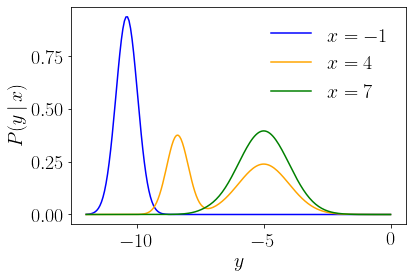

In [7]:
y = np.linspace(-12, 0, 200)
x_obs = np.array([-1, 4, 7])
for i, x in enumerate(x_obs):
    y_cpdf = np.array([cGMM.conditional_pdf([yi], x) for yi in y])
    plt.plot(y, y_cpdf, label=r"$x={x}$".format(x=x), color=colors[i])
plt.xlabel(r"$y$")
plt.ylabel(r"$P(y\,|\,x)$")
plt.legend(frameon=False)
plt.savefig("figures/cPDF_2comps.png", dpi=300, bbox_inches="tight");

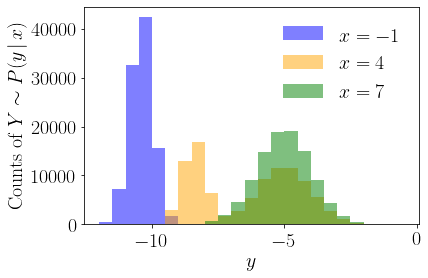

In [8]:
x_obs = np.array([-1, 4, 7])
bins = np.arange(-12, 0, 0.5)
N = 100000
for i, x in enumerate(x_obs):
    y_rvs = cGMM.rvs(x, size=N)
    plt.hist(y_rvs, bins=bins, label=r"$x={x}$".format(x=x), density=False, color=colors[i], alpha=0.5)
plt.xlabel(r"$y$")
plt.ylabel(r"Counts of $Y\sim P(y\,|\,x)$")
plt.legend(frameon=False)
plt.savefig("figures/hist_2comps.png", dpi=300, bbox_inches="tight");

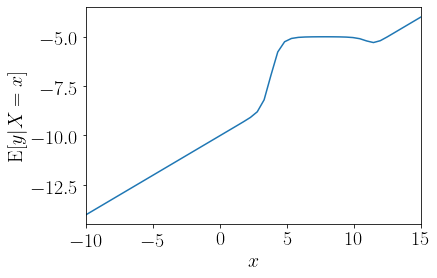

In [9]:
#Conditional means
x_obs = np.linspace(-10, 15)
y_mean = np.zeros_like(x_obs)
for i, x in enumerate(x_obs):
    y_mean[i] = cGMM.conditional_mean([x])
plt.plot(x_obs, y_mean)
plt.xlim(min(x_obs), max(x_obs))
plt.xlabel(r"$x$")
plt.ylabel(r"${\rm E}[y|X=x]$")
plt.savefig("figures/conditional_means_2comps.png", dpi=300, bbox_inches="tight");